<a href="https://colab.research.google.com/github/kdh1647/Bumblebee2/blob/master/DRB_PO_LSTM_1DCNN_WeekForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Lambda, Embedding
from keras.losses import Huber

import datetime

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data Read

In [4]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/kdh1647/Bumblebee2/master/B72W2_3MA_5MA_PS.csv')

In [5]:
raw_df.head

<bound method NDFrame.head of       OrderDate  YYYYWEEK  OrderQty     3MA    5MA     PS
0    2013-01-07    201302       262  243.01  227.0  472.5
1    2013-01-14    201303       411  426.67  411.2  567.0
2    2013-01-21    201304       373  349.66  360.4  472.5
3    2013-01-28    201305       272  306.00  338.2  570.6
4    2013-02-04    201306       525  484.33  354.4  385.2
..          ...       ...       ...     ...    ...    ...
504  2022-08-29    202235       257  429.66  597.2  394.6
505  2022-09-05    202236       223  298.67  295.6  392.0
506  2022-09-13    202237       415  360.01  317.6  490.0
507  2022-09-19    202238       656  610.67  573.4  490.0
508  2022-09-26    202239       248  343.33  439.6  490.0

[509 rows x 6 columns]>

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OrderDate  509 non-null    object 
 1   YYYYWEEK   509 non-null    int64  
 2   OrderQty   509 non-null    int64  
 3   3MA        509 non-null    float64
 4   5MA        509 non-null    float64
 5   PS         509 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 24.0+ KB


In [7]:
#모델평가 Mean Absolut Percentage Error
def MAPE_Val(y_pred, y_true):    
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [8]:
raw_df.OrderDate = pd.to_datetime(raw_df['OrderDate'], format='%Y-%m-%d')

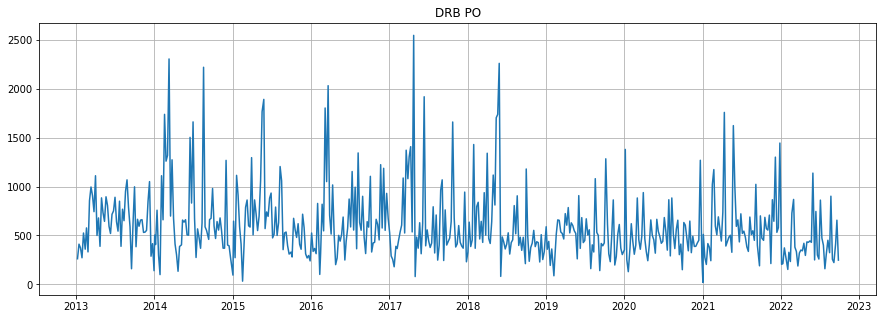

In [9]:
plt.figure(figsize=(15, 5)) 
plt.title('DRB PO')
plt.grid()

plt.plot(raw_df['OrderDate'], raw_df['OrderQty'])
plt.show()

### Data Preprocessing

In [10]:
raw_df.describe()

,YYYYWEEK,OrderQty,3MA,5MA,PS
count,509.000000,509.000000,509.000000,509.000000,509.000000
mean,201765.424361,600.524558,600.485187,600.505305,496.766601
std,281.851794,362.254035,357.365509,332.379252,97.821199
min,201301.000000,20.000000,34.000000,60.000000,77.500000
25%,201524.000000,377.000000,378.000000,386.600000,467.500000
50%,201747.000000,513.000000,510.340000,530.200000,498.000000
75%,202018.000000,690.000000,698.340000,700.400000,575.400000
max,202239.000000,2544.000000,2628.670000,2445.000000,714.500000


### 결측치 제거

In [12]:
raw_df.isnull().sum()

OrderDate    0
YYYYWEEK     0
OrderQty     0
3MA          0
5MA          0
PS           0
dtype: int64

In [13]:
#컬럼에 0의 개수 확인
for col in raw_df.columns:
    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ':' + str(missing_rows))

OrderDate:0
YYYYWEEK:0
OrderQty:0
3MA:0
5MA:0
PS:0


In [14]:
raw_df.loc[raw_df['5MA'].isna()]

,OrderDate,YYYYWEEK,OrderQty,3MA,5MA,PS


In [15]:
#missing data 처리
raw_df = raw_df.dropna()
raw_df.isnull().sum()

OrderDate    0
YYYYWEEK     0
OrderQty     0
3MA          0
5MA          0
PS           0
dtype: int64

### 정규화

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()
scale_col = ['OrderQty', '3MA', '5MA', 'PS']

In [18]:
scaled_df = scaler.fit_transform(raw_df[scale_col])
scaled_df

array([[0.09587956, 0.0805536 , 0.07002096, 0.62009419],
       [0.15491284, 0.15133716, 0.14725367, 0.76844584],
       [0.13985737, 0.12165709, 0.12595388, 0.62009419],
       ...,
       [0.15649762, 0.12564604, 0.10800839, 0.64756672],
       [0.25198098, 0.22225177, 0.21526205, 0.64756672],
       [0.09033281, 0.11921747, 0.15916143, 0.64756672]])

In [24]:
# scaled_df = pd.DataFrame(scaled_df, columns=scale_col)    #ndarray array -> DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=scale_col)

In [25]:
scaled_df['OrderDate'] = raw_df['OrderDate']

In [26]:
scaled_df.query("OrderQty == 0.0 ")

,OrderQty,3MA,5MA,PS,OrderDate


In [22]:
scaled_df = scaled_df.drop(417)

In [23]:
scaled_df.query("OrderQty == 0.0 ")

,OrderQty,3MA,5MA,PS,OrderDate


### 수요예측을 위해 3MA, 5MA, ORDERQTY항목을 feature 선정
  - 정답은 ORDERQTY 선정
  - 시계열 데이터를 위한 windows size = 20

In [30]:
# 입력 파라미터 feature, label => numpy type
def make_sequence_dataset(feature, label, window_size):
    feature_list = []    #생성될 feature list
    label_list = []      #생설될 label list
    
    for i in range(len(feature)-windows_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
    
    return np.array(feature_list), np.array(label_list)

In [31]:
# feature_df, lablel_df 생성
# feature_cols = ['OrderQty', '3MA', '5MA', 'PS']
# feature_cols = ['OrderQty','5MA', 'PS']
feature_cols = ['OrderQty']
label_cols = ['OrderQty']

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [32]:
# Dataframe -> numpy 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(508, 1) (508, 1)


### 시계열 데이터 생성 (make_sequence_dataset)

In [33]:
windows_size = 12
X, Y = make_sequence_dataset(feature_np, label_np, windows_size)

In [34]:
print(X.shape, Y.shape)

(496, 12, 1) (496, 1)


### 학습데이터, 테스트데이터 생성

In [35]:
#train, test 분리
split = -round(len(X) * 0.2)

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(397, 12, 1) (397, 1)
(99, 12, 1) (99, 1)


In [36]:
x_train[0].shape

(12, 1)

### LSTM Model and Compile

In [82]:
#모델생성
model = Sequential()
# model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))
model.add(LSTM(128, return_sequences=True, input_shape=x_train[0].shape))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 128)           66560     
                                                                 
 dropout_3 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 12, 50)            35800     
                                                                 
 dropout_4 (Dropout)         (None, 12, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [84]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

### 모델학습 (Early Stop)

In [85]:
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [104]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=10, callbacks=[early_stop])
# model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=40)

40/40 [==============================] - 1s 32ms/step - loss: 0.0215 - mae: 0.1047 - val_loss: 0.0155 - val_mae: 0.0855


In [105]:
pred = model.predict(x_test)

4/4 [==============================] - 2s 12ms/step


In [106]:
pred.shape

(99, 1)

In [107]:
x_value = scaled_df.iloc[split:, 4:5].copy()

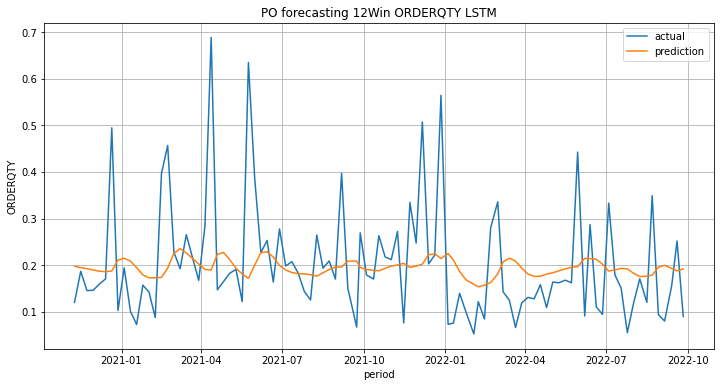

In [108]:
plt.figure(figsize=(12,6))
plt.title('PO forecasting 12Win ORDERQTY LSTM')
plt.ylabel('ORDERQTY')
plt.xlabel('period')
plt.plot(x_value.OrderDate, y_test, label='actual')
plt.plot(x_value.OrderDate, pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [109]:
# MAPE
# print(np.sum(abs(y_test-pred)/y_test)/len(x_test))
MAPE_Val(pred, y_test)

0.5157547531883901

## 1D CNN 모델

In [110]:
from keras.layers import Conv1D, GlobalAveragePooling1D, Flatten, GlobalAveragePooling1D, MaxPooling1D

In [111]:
cnn_model = Sequential()
cnn_model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[windows_size]))
cnn_model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'))
# cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu'))
cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1))

In [112]:
cnn_model.compile(optimizer='adam', loss='huber', metrics=['mae'])
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 12, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 12, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            6208      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                      

In [129]:
cnn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=10, callbacks=[early_stop])

40/40 [==============================] - 0s 7ms/step - loss: 0.0105 - mae: 0.1026 - val_loss: 0.0078 - val_mae: 0.0853


In [130]:
cnn_pred = cnn_model.predict(x_test)

4/4 [==============================] - 0s 4ms/step


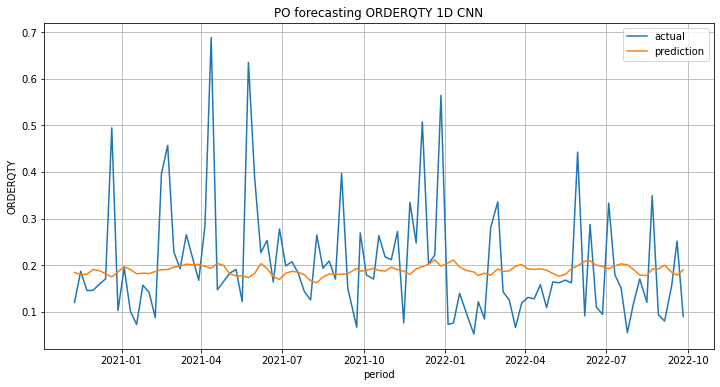

In [131]:
plt.figure(figsize=(12,6))
plt.title('PO forecasting ORDERQTY 1D CNN')
plt.ylabel('ORDERQTY')
plt.xlabel('period')
plt.plot(x_value.OrderDate, y_test, label='actual')
plt.plot(x_value.OrderDate, cnn_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [132]:
MAPE_Val(cnn_pred, y_test)

0.5087400771164708